# Marked exercises after Lecture 4
This notebook contains the marked exercises with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you may also find questions. Try to reflect on the questions before/after running the code.

You have four exercises to complete. In total, you can get **20 points** out of 60 points for Submission 1 for completing all marked exercises related to lecture 4.

Any reproduction or distribution of this document, in whole or in part, is prohibited unless permission is granted by the authors.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution).

<!--
SPDX-FileCopyrightText: Copyright (c) 2019-2025 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
-->

In [1]:
import getpass
import os
import random
import re
import tarfile
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
#For efficient usage of the hardware resources when running on JupyterHub EPFL,
# we will limit the number of threads. If you are running this code on your local
# machine or on colab, the following code will not do anything.
if getpass.getuser() == "jovyan":
    num_threads_limit = 4
elif re.search('^https://gnoto\\.epfl\\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
   num_threads_limit = 4
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Limiting the number of threads to 4
PyTorch is using 4 threads


In [3]:
from torchvision import transforms
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Loading the CIFAR-10 dataset. The dataset is already accessible on Gnoto.
# If you are using another environment, you need to set root='./data' and download=True
train_dataset = datasets.CIFAR10(root='/EE559-shared/CIFAR10/', train=True, download=False, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='/EE559-shared/CIFAR10/', train=False, download=False, transform=transforms_cifar)

from torch.utils.data import Subset

torch.manual_seed(42)

#we are not using the whole dataset to reduce the training and test time for the assignment
train_dataset = Subset(train_dataset, range(30000))
test_dataset = Subset(test_dataset, range(2000))

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)


The code for this part is taken from Practice 3 lab. For more detailed information, look at the solutions for Practice_3.ipynb.

/opt/jlab-env/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/jlab-env/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


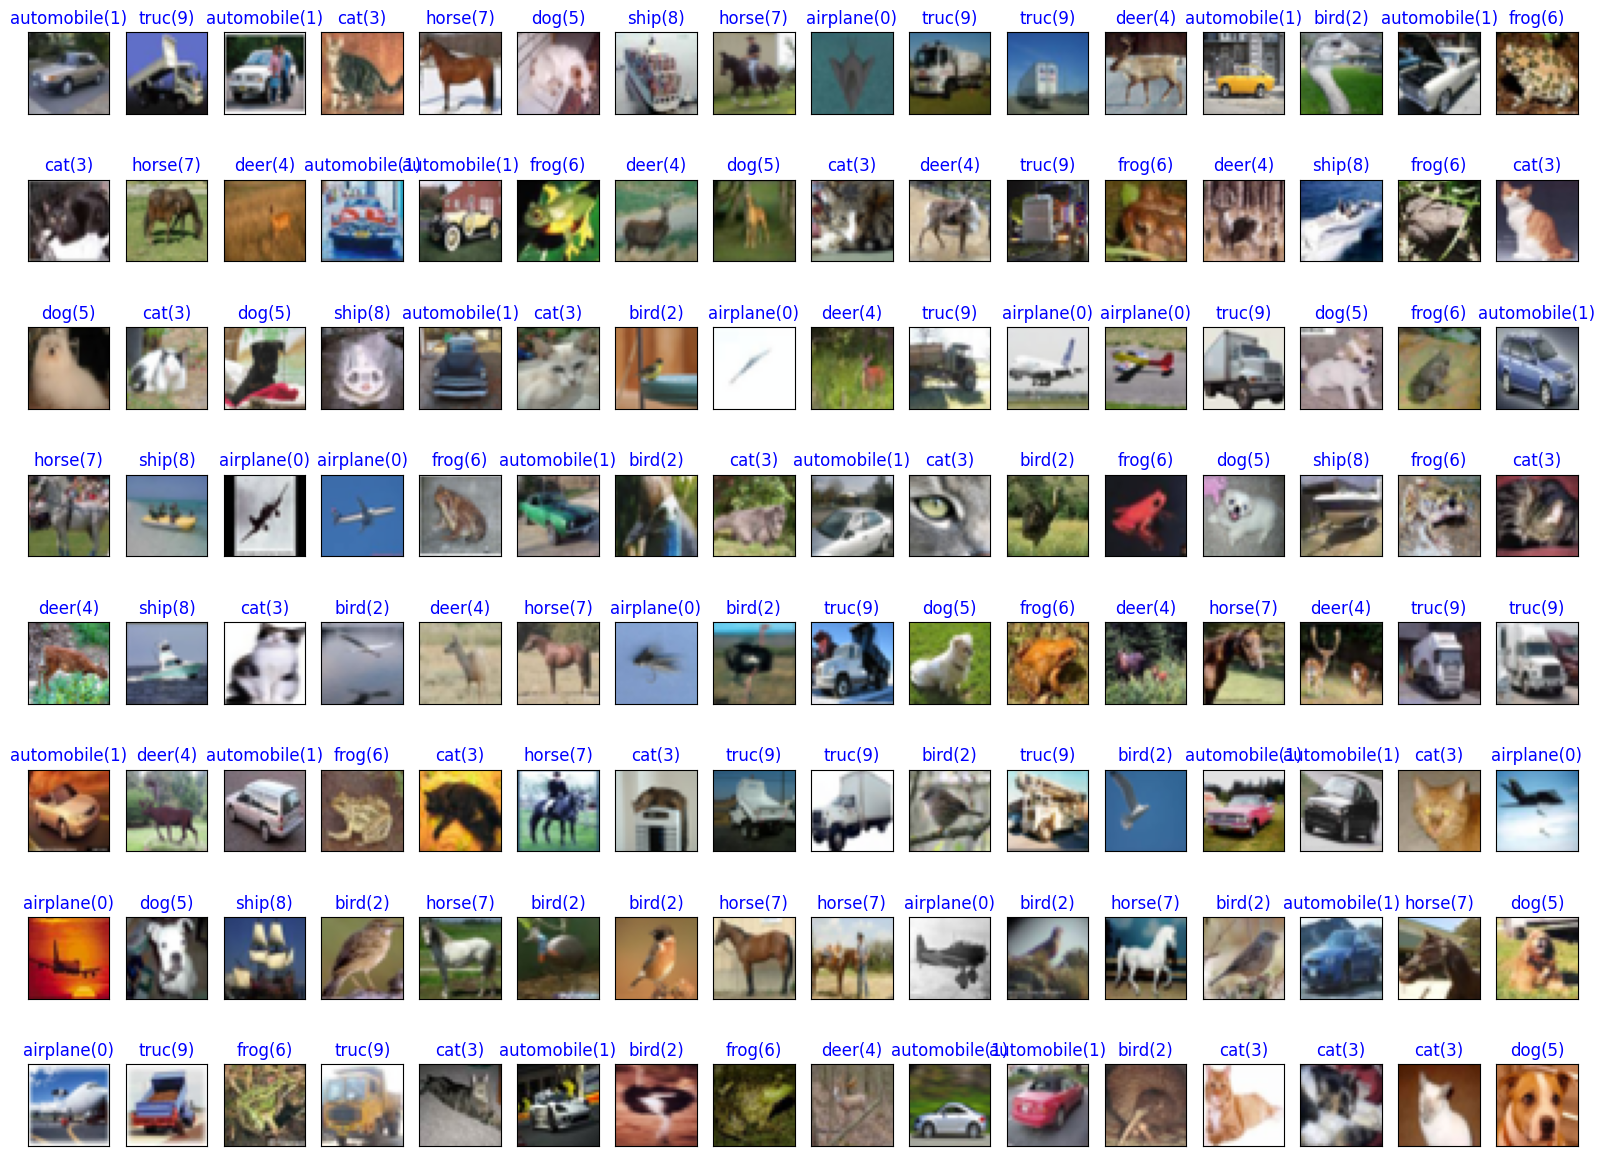

In [4]:
# Visualization of images

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truc']
def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    fig = plt.figure(figsize=(20, 15))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(8, int(batch_size/8), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

/opt/jlab-env/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/jlab-env/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


images per class in dataloader:  {'horse': 3042, 'frog': 3016, 'cat': 3008, 'dog': 2954, 'automobile': 3023, 'deer': 2999, 'truc': 2995, 'ship': 2973, 'bird': 3007, 'airplane': 2983}


/tmp/ipykernel_155/1959498461.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


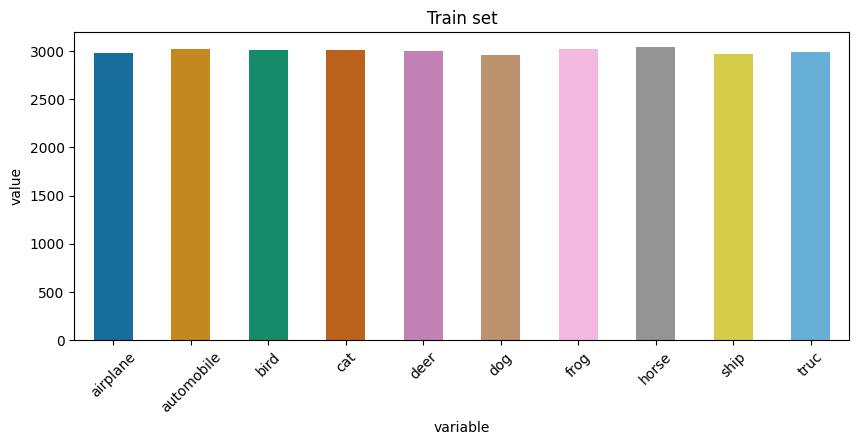

In [5]:
# class distribution
import seaborn as sns
from collections import Counter


def plot_class_distribution_for_dataloader(dataloader):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for _, target in dataloader:
        for t in target:
            t = classes[int(t)]
            if t not in count_dict:
                count_dict[t] = 0
            count_dict[t] += 1
    print("images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class ditribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title("Train set")
    plt.xticks(rotation=45)
    plt.legend().set_visible(False)
    plt.show()

plot_class_distribution_for_dataloader(train_loader)
## the training set is perfectly balanced: same number of image for all classes

images per class in dataloader:  {'cat': 199, 'ship': 217, 'airplane': 196, 'frog': 216, 'automobile': 198, 'truc': 203, 'dog': 185, 'horse': 193, 'deer': 198, 'bird': 195}


/tmp/ipykernel_155/1959498461.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


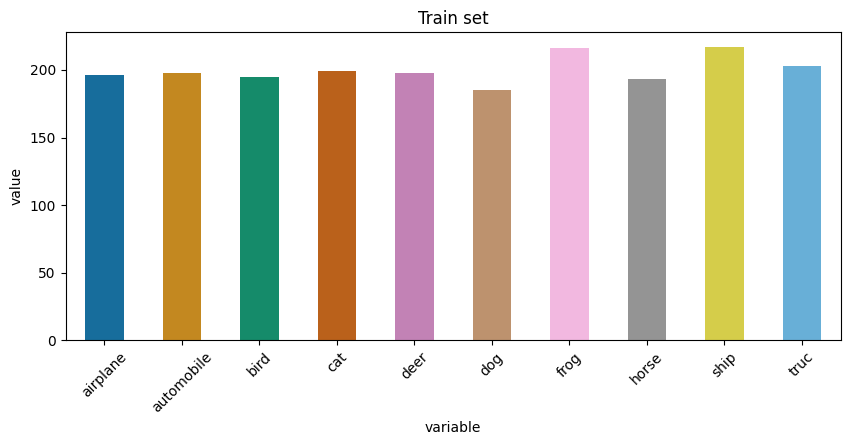

In [6]:
plot_class_distribution_for_dataloader(test_loader)

Metrics

In [7]:
from sklearn.metrics import f1_score, accuracy_score
def f1(preds, target):
    return f1_score(target.detach().cpu(), preds.detach().cpu(), average='macro')

def acc(preds, target):
    return accuracy_score(target.detach().cpu(), preds.detach().cpu())

Training

In [8]:
## this a simple function for trainin on one epoch.
#It is written here just as a reference for you. It will not be used in this assignmnet

from tqdm import tqdm #to see the progress of training
from IPython.display import clear_output



def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    model.train() #set a model in a training mode

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        #clean previously computed gradients
        optimizer.zero_grad()

        # forward
        outputs = model(data)

        #compute predictions
        with torch.no_grad():
            _, preds = torch.max(outputs, 1)

        #compute loss
        loss = criterion(outputs, target)

        #do backward and oprimizer steps
        loss.backward()
        optimizer.step()

        # compute metrics
        # no gradients should be propagated at this step
        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)


        # log loss statistics
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [9]:
def evaluate(model, criterion, metrics, test_loader, device):
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    model.eval() #set a model in a evaluation mode

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # we don't compute gradients here
            data = x_batch.to(device)
            target = y_batch.to(device)

            #forward
            outputs = model(data)

            #compute loss
            loss = criterion(outputs, target)

            #compute predictions
            _, preds = torch.max(outputs, 1)

            # compute metrics
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds, target)

            # log loss statistics
            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [10]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()



In [11]:
def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log


def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


Measuring model's size and inference time

In [12]:
import os
import time
# functions to measure models weights size and inference time
def get_model_size(model_path):
    #sz = os.stat(model_path)
    file_size = os.path.getsize(model_path)
    print('model weights file size in MB:', file_size / 1024 /1024)
    return file_size / 1024 /1024


def get_model_inference_time(model):
    model.to(torch.device('cpu'))
    input = torch.rand((128, 3, 32, 32))

    start = time.time()
    out = model(input)
    end = time.time()
    assert out.shape[0] == 128
    print('model inference time in seconds:', end - start)
    return end - start

Defining the cross-entropy loss and metrics

In [13]:
criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}

In [14]:
# the device (CPU or GPU) to use for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Teacher model**

The teacher model is a model that we will try to distill into a smaller student model. In this assignment the teacher model is a MobileNetV2 network trained on CIFAR10 dataset.
It has 2,236,682 parameters and its weights file weight around 8.767 MB.

In [15]:
# MIT Copyright (c) 2019 Huy Phan. Model taken from https://github.com/huyvnphan/PyTorch_CIFAR10/

# Note: make sure to add the 'mobilenet_v2.pt' and 'mobilenetv2.py' files into the current working directory
from mobilenetv2 import mobilenet_v2

# Pretrained teacher model
teacher_model = mobilenet_v2()
get_model_inference_time(teacher_model)
teacher_model_weights_path = 'mobilenet_v2.pt'
teacher_model.load_state_dict(torch.load(teacher_model_weights_path))
teacher_model.to(device)

print('model size', get_model_size(teacher_model_weights_path))

print('teacher performance:')
test_loss, test_metrics = evaluate(teacher_model, criterion, metrics, test_loader, device)

from torchsummary import summary
summary(teacher_model, (3, 32, 32))
#accuracy of a teacher model should be around 0.93


model inference time in seconds: 0.7226932048797607


/tmp/ipykernel_155/1239766684.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(teacher_model_weights_path))


model weights file size in MB: 8.767388343811035
model size 8.767388343811035
teacher performance:
eval Loss: 0.2463,  ACC: 0.9355, F1-weighted: 0.9315
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
             ReLU6-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 96, 32, 32]           1,536
      BatchNorm2d-11           [-1, 96, 32, 32]             192
            ReL

**Student model**

##### 1.4.1 Implement student network [5 points] and 1.4.2 Implement initialisation of the model [6 points]

For the student network you need to implement a simple CNN for 10-class classification. Its weights should weight >= 2MB and <= 4MB.

You also need to implement initialisation of the model's weights. Think, which is the best initialisation for each layer/ type of layer and implement it in 
``` def init_weights(module) ``` 
, where module is a module of the network. The initialisation is going to be done through 
``` student_model.apply(init_weights)```
(you can read more about `apply` function here (https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply).
You can learn more about different initialisations in PyTorch here https://pytorch.org/docs/stable/nn.init.html. You should initialise **every trainable parameter of the network with your code**.


In [16]:
# student model
'''
TODO: design your own CNN student model for 10 class classification for training with distillation
the model should weight >= 2MB and <= 4MB
'''
class StudentModel(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentModel, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        #out = ...
        # YOUR CODE HERE
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

    '''
    TODO: implement initialisation for trainable parameters of the model.
    Make sure that initialisation is logical and is suitable for a parameter.
    '''
    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

#init the model
student_model = StudentModel()
torch.save(student_model.state_dict(), 'student_model_before_init.pt')
student_model.apply(student_model.init_weights) #applies initialisation

#get inference time for student network
get_model_inference_time(student_model)

student_model.to(device)

student_model_weights_path = 'student_model_after_init.pt'
#save model
torch.save(student_model.state_dict(), student_model_weights_path)


student_sz = get_model_size(student_model_weights_path)
print('model size', student_sz)
#checking the weight of the model
assert student_sz <= 4
assert student_sz >= 2


from torchsummary import summary
print('model summary')
summary(student_model, (3, 32, 32))

model inference time in seconds: 0.0390627384185791
model weights file size in MB: 2.3780441284179688
model size 2.3780441284179688
model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
        MaxPool2d-12 

##### 1.4.3 Implement training with distillation [7 points]
Knowledge distillation was proposed by Geoffrey Hinton, Oriol Vinyals, and Jeff Dean in "Distilling the knowledge in a neural network." (2015) https://arxiv.org/abs/1503.02531.


If you try to train a small student network from scratch, you are likely to get relatively low performance. You can improve the test accuracy of the student network by incorporating the teacher. Knowledge distillation is a straightforward technique to achieve this, based on the fact that both networks are solving the same task (10 class CIFAR10 classification in our case) and output a probability distribution over our classes. Therefore, the two networks share the same number of output neurons.

An obvious way to transfer the generalization ability of the cumbersome teacher model to a small model is to use the class probabilities produced by the teacher model as “soft targets” for training the small model (distillation loss, objective 1).

Additionally, when the correct labels are known for all or some of the transfer set, knowledge distillation can be significantly improved by also training the student model to produce the correct labels (cross entropy loss, objective 2). Good way to combine two objectives is to simply use a weighted average of two different objective functions. The first objective function is the cross entropy with the soft targets and this cross entropy is computed using high temperature (the same high temperature in the softmax of the distilled model as was used for generating the soft targets from the teacher model). The second objective function is the cross entropy with the correct labels. This is computed using exactly the same logits in softmax of the student model but at a temperature of 1.

Summarizing, the knowledge distillation works by incorporating an additional loss into the traditional cross entropy loss, which is based on the softmax output of the teacher network. The assumption is that the output activations of a properly trained teacher network carry additional information that can be leveraged by a student network during training. The original work suggests that utilizing ratios of smaller probabilities in the soft targets can help achieve the underlying objective of deep neural networks, which is to create a similarity structure over the data where similar objects are mapped closer together. For example, in CIFAR-10, a truck could be mistaken for an automobile or airplane, if its wheels are present, but it is less likely to be mistaken for a dog. Therefore, it makes sense to assume that valuable information resides not only in the top prediction of a properly trained model but in the entire output distribution. However, cross entropy alone does not sufficiently exploit this information as the activations for non-predicted classes tend to be so small that propagated gradients do not meaningfully change the weights to construct this desirable vector space.''


In [17]:
def train_epoch_with_distillation(student_model, teacher_model, optimizer, criterion, metrics, train_loader, device, alpha=0.25, T=2):
    '''
    alpha: a hyperparameter.
           alpha - a weight assigned to the extra objective of teacher-student loss.
           1-alpha - a weight assigned to cross-entropy between student outouts and target.
           Tuning these weights pushes the network towards optimizing for either of two objectives.

    T: Temperature controls the smoothness of the output distributions.
       Larger T leads to smoother distributions, thus smaller probabilities get a larger boost.

    '''


    epoch_loss = 0 # Log loss statistics during training
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    # TODO implement training with distillation
    # metric computation should be organised the same way as in train_epoch

    # remember that a teacher model should not be trained and should be in inference mode


    # YOUR CODE HERE
    student_model.train()
    teacher_model.eval()  

    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()

        student_outputs = student_model(data)
        with torch.no_grad():
            teacher_outputs = teacher_model(data)

        log_student_soft = torch.log_softmax(student_outputs / T, dim=1)
        teacher_soft = torch.softmax(teacher_outputs / T, dim=1)
        loss_KL = torch.nn.functional.kl_div(log_student_soft, teacher_soft, reduction='batchmean') * (T * T)

        ce_loss = criterion(student_outputs, target)

        loss = alpha * loss_KL + (1 - alpha) * ce_loss

        loss.backward()
        optimizer.step()

        _, preds = torch.max(student_outputs, 1)
        for k in epoch_metrics.keys():
            epoch_metrics[k] += metrics[k](preds, target)

        epoch_loss += loss.item()    
    
    epoch_loss /= len(train_loader)

    for metric_name, metric_value in epoch_metrics.items():
        epoch_metrics[metric_name] /= len(train_loader)

    clear_output() #clean the prints from previous epochs
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss, epoch_metrics


# Modification of train_cycle function to include the teacher model
def train_cycle_with_distillation(student_model, teacher_model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device, alpha=0.25, T=2):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]

    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch_with_distillation(student_model, teacher_model, optimizer, criterion, metrics, train_loader, device, alpha=alpha, T=T)
        #evaluation is the same as for normal simple training.
        # Although, take into account that the loss computed for evaluation is a simple CrossEntropy loss and it will differ significantly from training loss
        test_loss, test_metrics = evaluate(student_model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

    return train_metrics_log, test_metrics_log



train Loss: 0.9026,  ACC: 0.7347, F1-weighted: 0.7253
eval Loss: 0.8237,  ACC: 0.7176, F1-weighted: 0.7027


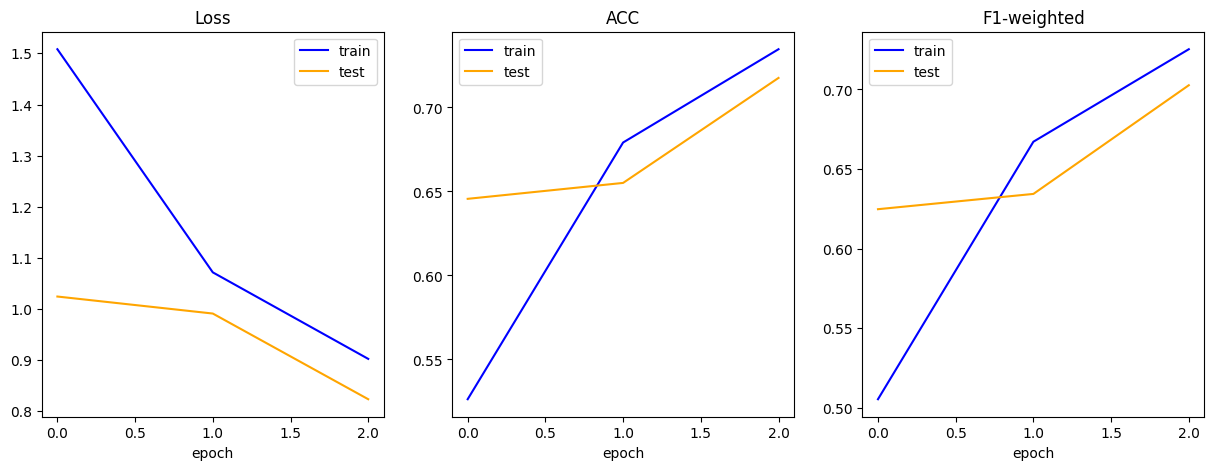

model weights file size in MB: 2.377617835998535
model size 2.377617835998535


In [18]:
# Pretrained teacher model
teacher_model = mobilenet_v2()
teacher_model_weights_path = 'mobilenet_v2.pt'
teacher_model.load_state_dict(torch.load(teacher_model_weights_path))

# Student model
student_model = StudentModel()


# if you have time and want to play with the hyperparameters, feel free to do so
# traing on CPU will take around 5 minutes per epoch.

#train your network on 3 epochs


learning_rate = 0.001
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)
N_EPOCHS = 3
alpha = 0.25
T = 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)
teacher_model.to(device)

train_metrics_log, test_metrics_log = train_cycle_with_distillation(student_model, teacher_model, optimizer,
                                                                    criterion, metrics, train_loader, test_loader,
                                                                    N_EPOCHS, device, alpha=alpha, T=T)

student_model_weights_path = 'student_model.pt'
torch.save(student_model.state_dict(), student_model_weights_path)

print('model size', get_model_size(student_model_weights_path))

#the performance of the student network should be around 0.70


##### 1.4.4 Apply the quantization to the trained student model. [2 points]
Get familiar with quantization techniques in PyTorch here https://pytorch.org/blog/introduction-to-quantization-on-pytorch/ .  Apply dynamic quantization to the trained student model. Note that due to the PyTorch limitations, the quantization will only be applied to the linear layers of your model, which is sufficient for this exercise. 

In [20]:
import torch.quantization

# quantized_student_model = ...
# YOUR CODE HERE
student_model.cpu()
quantized_student_model = torch.quantization.quantize_dynamic(student_model, {nn.Linear}, dtype=torch.qint8)
quantized_student_model.eval()

print('quantized student performance:')
test_q_loss, test_q_metrics = evaluate(quantized_student_model, criterion, metrics, test_loader, device='cpu')

quantized_student_model_weights_path = 'quantized_student_model.pt'
torch.save(quantized_student_model.state_dict(), quantized_student_model_weights_path)

print('model size', get_model_size(quantized_student_model_weights_path))

quantized student performance:
eval Loss: 0.8239,  ACC: 0.7171, F1-weighted: 0.7023
model weights file size in MB: 0.8717794418334961
model size 0.8717794418334961
